In [1]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import numpy as np


c:\Users\Change\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\Change\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\Change\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


### Creating a one bus for the Netherlands

In [2]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)


network.add("Bus", "electricity bus", carrier="electricity")
network.add("Carrier", "electricity")  

network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

#### Getting the demand for the Netherlands and adding it to the bus

In [3]:
# Define file path
file_path = "Data/electricity_demand.csv"

# Load dataset
data = pd.read_csv(file_path, sep=';', parse_dates=['utc_time'], index_col='utc_time')
data.index = pd.to_datetime(data.index, utc=True)
# Convert index to datetime format
data.index = pd.to_datetime(data.index, utc=True)

start_date = '2015-01-01 00:00:00+00:00'
end_date = '2015-12-31 23:00:00+00:00'

data = data[start_date:end_date]
country = 'NLD'
data = data[country]
print(data.head())

utc_time
2015-01-01 00:00:00+00:00    11338.0
2015-01-01 01:00:00+00:00    10917.0
2015-01-01 02:00:00+00:00    10473.0
2015-01-01 03:00:00+00:00    10200.0
2015-01-01 04:00:00+00:00    10182.0
Name: NLD, dtype: float64


In [4]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set = data.values)

Index(['load'], dtype='object')

In [5]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,11338.0
2015-01-01 01:00:00,10917.0
2015-01-01 02:00:00,10473.0
2015-01-01 03:00:00,10200.0
2015-01-01 04:00:00,10182.0
...,...
2015-12-31 19:00:00,12958.0
2015-12-31 20:00:00,12263.0
2015-12-31 21:00:00,11772.0


#### Adding different generation types 

In [6]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n
    
print(annuity(25,0.07))
print(annuity(25,0.07)*425000*(1+0.03))

0.0858105172206656
37563.55391334636


In [7]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "coal", co2_emissions=0.363) # in /MWh_tt_CO2h
network.add("Carrier", "offshorewind")
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "nuclear")
network.add("Carrier", "gas", co2_emissions=0.22) # in /MWh_tt_CO2h



# add onshore wind generator
df_onshorewind = pd.read_csv('Data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind_on = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*1088000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=7000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_on.values)

# add offshore wind generator
df_offshorewind = pd.read_csv('Data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
CF_wind_off = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshorewind = annuity(30,0.07)*2084520*(1+0.033) # in €/MW
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=7000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_off.values)

# add solar PV generator
df_solar = pd.read_csv('Data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*600290*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add Gas CC W/o ccts
capital_cost_CCGT = annuity(30,0.07)*1300000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.58 # MWh_elec/MWh_th
VOM_gas = 4 # in €/MWh
marginal_cost_CCGT = VOM_gas + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "CCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=7000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)


# add coal power plant  generator coal IGCC W/o ccts
capital_cost_coal = annuity(40,0.07)*3088000*(1+0.03) # in €/MW
fuel_cost = 8.4 # in €/MWh_th
efficiency = 0.392 # MWh_elec/MWh_th
VOM_coal = 6 # in €/MWh
marginal_cost_coal = VOM_coal + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=7000,
            capital_cost = capital_cost_coal,
            marginal_cost = marginal_cost_coal)


# add nuclear power plant generator
capital_cost_nuclear = annuity(45,0.07)*8594000*(1+0.027) # in €/MW
fuel_cost = 3 # in €/MWh_th 
efficiency = 0.33 # MWh_elec/MWh_th
VOM_nuclear = 10 # in €/MWh
marginal_cost_nuclear = VOM_nuclear + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "nuclear",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="nuclear",
            #p_nom_max=7000,
            capital_cost = capital_cost_nuclear,
            marginal_cost = marginal_cost_nuclear)

Index(['nuclear'], dtype='object')

In [8]:
network.generators_t.p_max_pu

Generator,offshorewind,onshorewind,solar
snapshot,,,
2015-01-01 00:00:00,0.734,0.360,0.0
2015-01-01 01:00:00,0.758,0.383,0.0
2015-01-01 02:00:00,0.787,0.417,0.0
2015-01-01 03:00:00,0.794,0.432,0.0
2015-01-01 04:00:00,0.802,0.443,0.0
...,...,...,...
2015-12-31 19:00:00,0.798,0.448,0.0
2015-12-31 20:00:00,0.798,0.465,0.0
2015-12-31 21:00:00,0.794,0.451,0.0


In [9]:
network.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]
INFO:linopy.io: Writing time: 2.1s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-3wv1iv53.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-3wv1iv53.lp


Reading time = 0.68 seconds


INFO:gurobipy:Reading time = 0.68 seconds


obj: 113886 rows, 52566 columns, 205855 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 205855 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 205855 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 205855 nonzeros


Model fingerprint: 0x3c640133


INFO:gurobipy:Model fingerprint: 0x3c640133


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [2e+01, 6e+05]


INFO:gurobipy:  Objective range  [2e+01, 6e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [9e+03, 2e+04]


INFO:gurobipy:  RHS range        [9e+03, 2e+04]


Presolve removed 56957 rows and 4391 columns


INFO:gurobipy:Presolve removed 56957 rows and 4391 columns


Presolve time: 1.64s


INFO:gurobipy:Presolve time: 1.64s


Presolved: 56929 rows, 48175 columns, 144507 nonzeros


INFO:gurobipy:Presolved: 56929 rows, 48175 columns, 144507 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 9.634e+04


INFO:gurobipy: AA' NZ     : 9.634e+04


 Factor NZ  : 5.298e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 5.298e+05 (roughly 50 MB of memory)


 Factor Ops : 5.161e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.161e+06 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.12042615e+10  0.00000000e+00  1.21e+05 0.00e+00  3.47e+07     4s


INFO:gurobipy:   0   7.12042615e+10  0.00000000e+00  1.21e+05 0.00e+00  3.47e+07     4s


   1   9.82768411e+10 -1.37686853e+11  1.87e+04 3.77e+02  8.34e+06     4s


INFO:gurobipy:   1   9.82768411e+10 -1.37686853e+11  1.87e+04 3.77e+02  8.34e+06     4s


INFO:gurobipy:


Barrier performed 1 iterations in 4.30 seconds (0.13 work units)


INFO:gurobipy:Barrier performed 1 iterations in 4.30 seconds (0.13 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   39611    6.5737120e+09   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:   39611    6.5737120e+09   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:


Solved in 39611 iterations and 5.42 seconds (0.98 work units)


INFO:gurobipy:Solved in 39611 iterations and 5.42 seconds (0.98 work units)


Optimal objective  6.573712049e+09


INFO:gurobipy:Optimal objective  6.573712049e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 6.57e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [10]:
print(network.objective/1000000) #in 10^6 €

6573.712049064885


In [11]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    58.046086
dtype: float64


In [12]:
network.generators.p_nom_opt # in MW

Generator
onshorewind      1083.333333
offshorewind        0.000000
solar               0.000000
CCGT            17545.250000
coal                0.000000
nuclear             0.000000
Name: p_nom_opt, dtype: float64

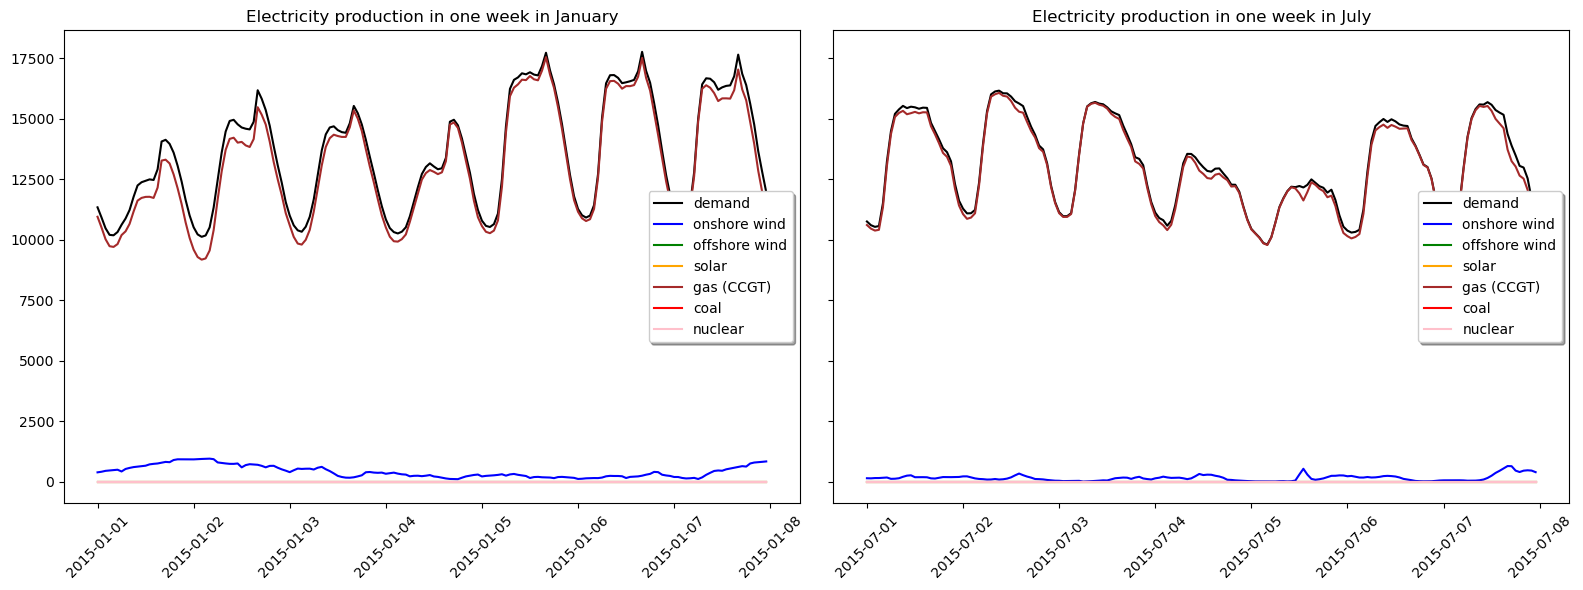

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Electricity mix

Text(0.5, 1.07, 'Electricity mix')

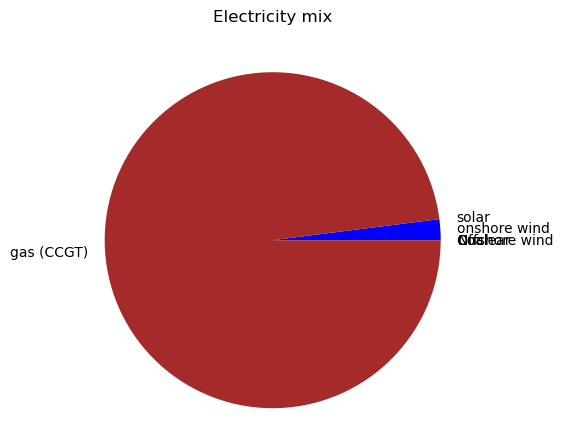

In [14]:
labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum(),
        network.generators_t.p['nuclear'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'red', 'pink']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [15]:
# Group dispatch by carrier manually
dispatch = network.generators_t.p
carrier_map = network.generators.carrier

# Match generator names to carriers
dispatch.columns = carrier_map[dispatch.columns].values

C:\Users\Change\AppData\Local\Temp\ipykernel_49048\1457957073.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



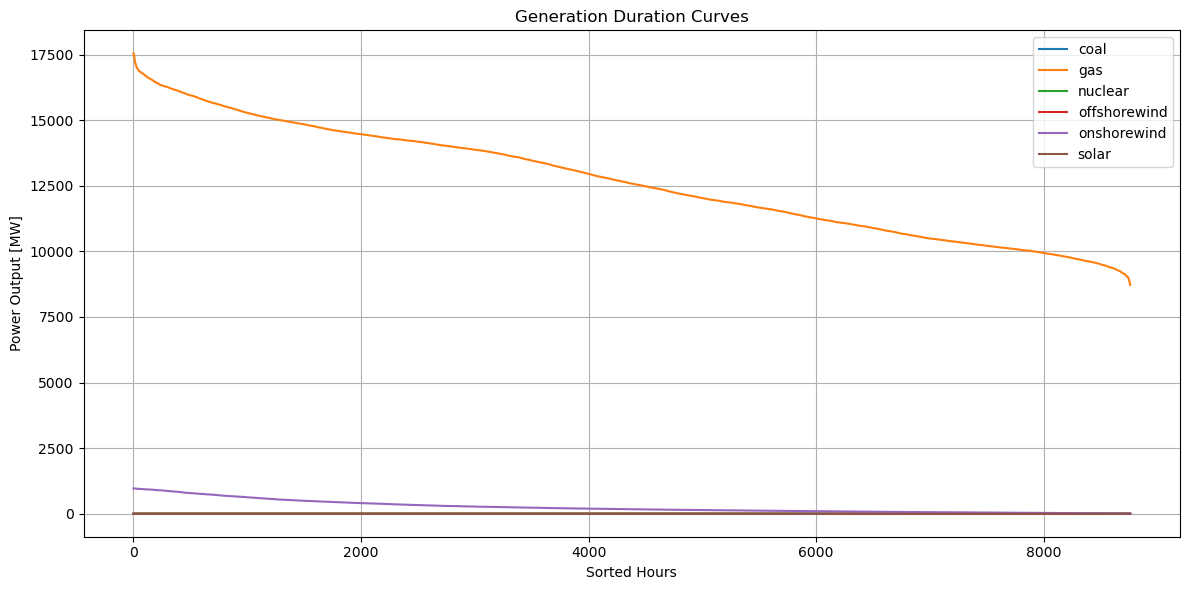

In [16]:
# Sum all generators by carrier
carrier_dispatch = dispatch.groupby(axis=1, level=0).sum()
# Duration curves
carrier_dispatch.apply(lambda x: x.sort_values(ascending=False).reset_index(drop=True)).plot(
    figsize=(12, 6), title="Generation Duration Curves")
plt.ylabel("Power Output [MW]")
plt.xlabel("Sorted Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

## CO2 limit 

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]
INFO:linopy.io: Writing time: 3.31s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-qbe3no09.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-qbe3no09.lp


Reading time = 0.66 seconds


INFO:gurobipy:Reading time = 0.66 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 6.92e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Generator
onshorewind     20301.695437
offshorewind        0.000000
solar           14475.825252
CCGT            17372.284741
coal                0.000000
nuclear             0.000000
Name: p_nom_opt, dtype: float64

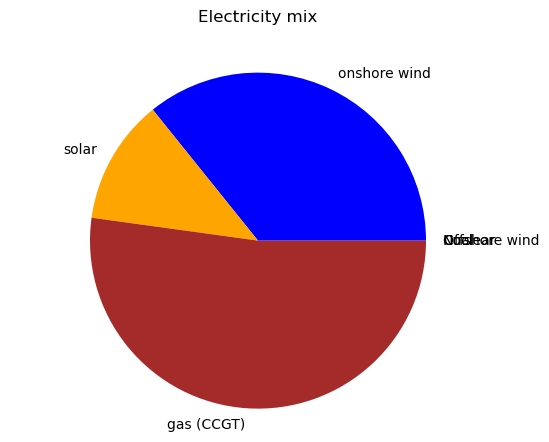

In [17]:
co2_limit=13000000#tonCO2
network.add("GlobalConstraint",
            "co2_limit_13MT",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

#network.optimize(solver_name='gurobi')
network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})



labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum(),
        network.generators_t.p['nuclear'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'red', 'pink']    

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

network.generators.p_nom_opt # in MW



INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]
INFO:linopy.io: Writing time: 2.46s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-inw7lwj2.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-inw7lwj2.lp


Reading time = 0.75 seconds


INFO:gurobipy:Reading time = 0.75 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]
INFO:linopy.io: Writing time: 3.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-cah2ukc0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-cah2ukc0.lp


Reading time = 0.60 seconds


INFO:gurobipy:Reading time = 0.60 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]
INFO:linopy.io: Writing time: 2.11s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-hqthba1b.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-hqthba1b.lp


Reading time = 0.54 seconds


INFO:gurobipy:Reading time = 0.54 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
INFO:linopy.io: Writing time: 2.1s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-5jvikzx1.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-5jvikzx1.lp


Reading time = 0.42 seconds


INFO:gurobipy:Reading time = 0.42 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
INFO:linopy.io: Writing time: 2.12s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-2ijp5_9q.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-2ijp5_9q.lp


Reading time = 0.40 seconds


INFO:gurobipy:Reading time = 0.40 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]
INFO:linopy.io: Writing time: 2.75s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-xqotp0au.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-xqotp0au.lp


Reading time = 0.62 seconds


INFO:gurobipy:Reading time = 0.62 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]
INFO:linopy.io: Writing time: 2.58s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-2n9l1_gr.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-2n9l1_gr.lp


Reading time = 0.68 seconds


INFO:gurobipy:Reading time = 0.68 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]
INFO:linopy.io: Writing time: 2.72s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-vd6946ji.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-vd6946ji.lp


Reading time = 0.38 seconds


INFO:gurobipy:Reading time = 0.38 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  8.18it/s]
INFO:linopy.io: Writing time: 1.52s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-s6xovtt3.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-s6xovtt3.lp


Reading time = 0.42 seconds


INFO:gurobipy:Reading time = 0.42 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  7.94it/s]
INFO:linopy.io: Writing time: 2.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-ziiqci9y.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-ziiqci9y.lp


Reading time = 0.43 seconds


INFO:gurobipy:Reading time = 0.43 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


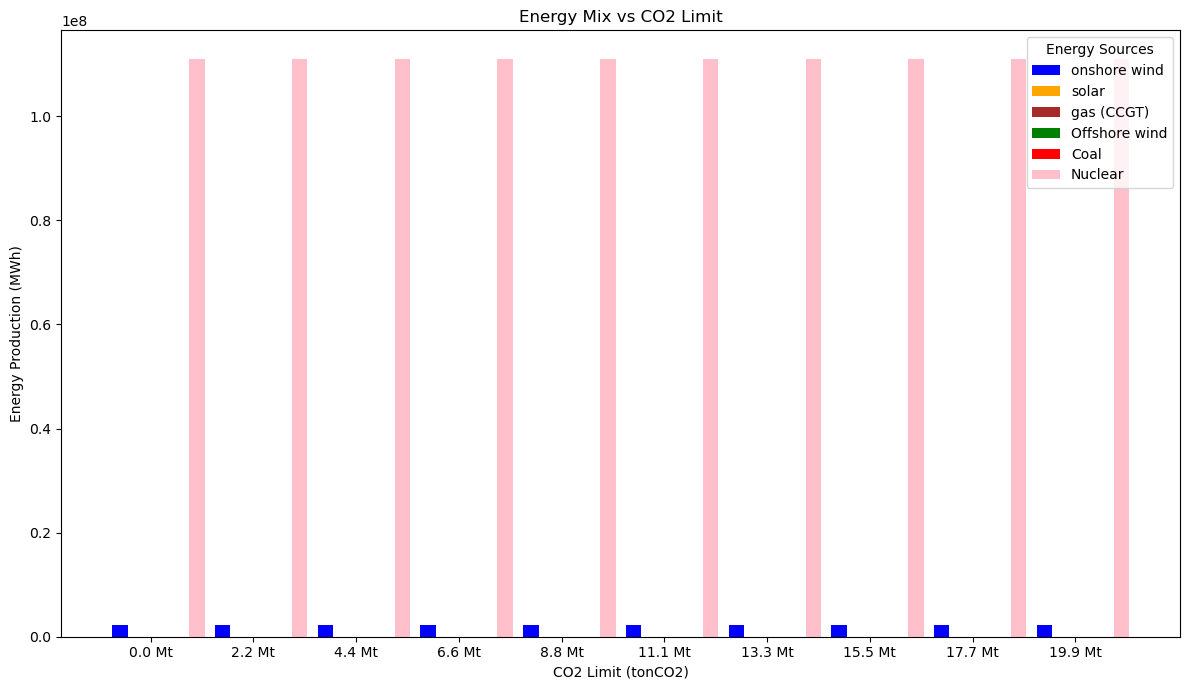

In [18]:
co2_limits = np.linspace(0, 19.9e6, 10)  
network.remove("GlobalConstraint", "co2_limit_13MT")

energy_mixes = []
for co2_limit in co2_limits:
    
    
    network.add("GlobalConstraint",
                "co2_limit",  
                type="primary_energy",
                carrier_attribute="co2_emissions",
                sense="<=",
                constant=co2_limit)
    network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})
    sizes = [network.generators_t.p['onshorewind'].sum(),
             network.generators_t.p['solar'].sum(),
             network.generators_t.p['CCGT'].sum(),
             network.generators_t.p['offshorewind'].sum(),
             network.generators_t.p['coal'].sum(),
             network.generators_t.p['nuclear'].sum()]
    energy_mixes.append(sizes)

energy_mixes = np.array(energy_mixes)


# Plot
labels = ['onshore wind', 'solar', 'gas (CCGT)', 'Offshore wind', 'Coal', 'Nuclear']
colors = ['blue', 'orange', 'brown', 'green', 'red', 'pink']
fig, ax1 = plt.subplots(figsize=(12, 7))
x = np.arange(len(co2_limits)) 
bar_width = 0.15 
for i, label in enumerate(labels):
    ax1.bar(x + i * bar_width, energy_mixes[:, i], bar_width, label=label, color=colors[i])
ax1.set_xlabel('CO2 Limit (tonCO2)')
ax1.set_ylabel('Energy Production (MWh)')
ax1.set_title('Energy Mix vs CO2 Limit')
ax1.set_xticks(x + bar_width * 2) 
ax1.set_xticklabels([f'{co2_limit / 1e6:.1f} Mt' for co2_limit in co2_limits]) 
ax1.legend(title="Energy Sources")
fig.tight_layout()

plt.show()


In [19]:
print(network.objective/1000000) #in 10^6 €

13598.554986190707


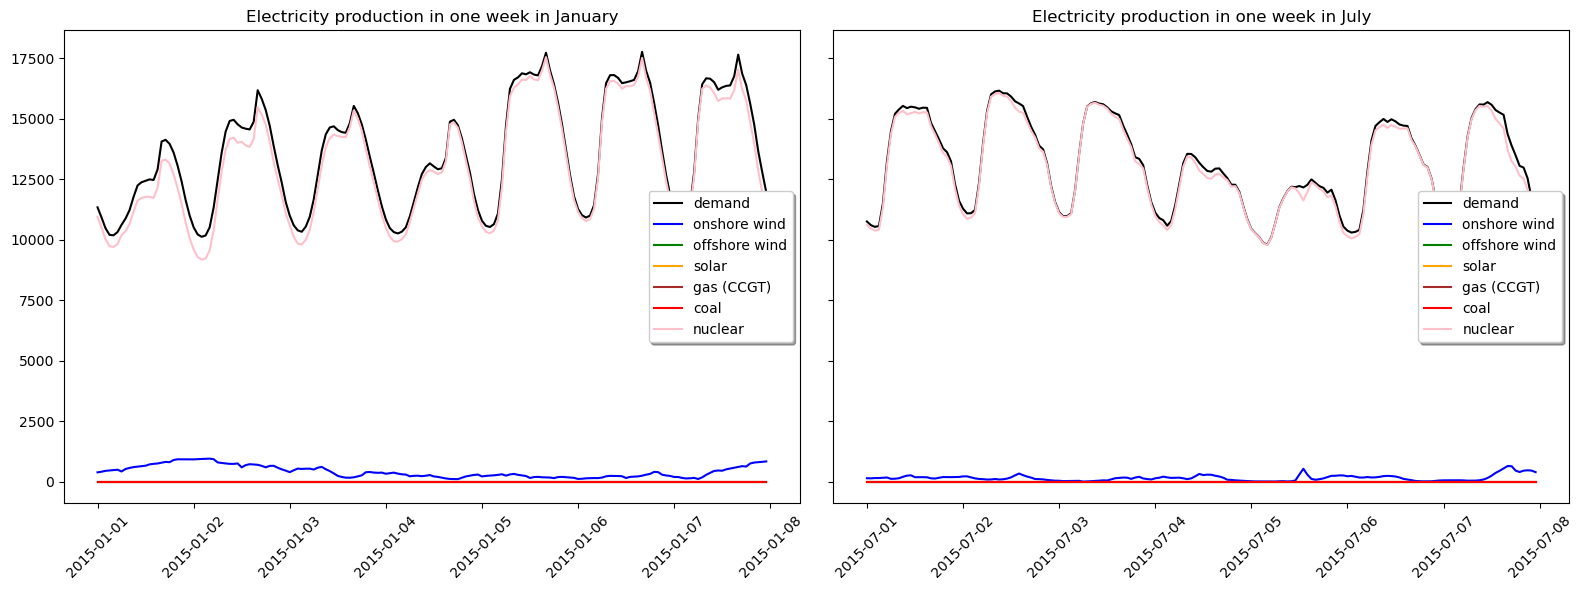

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Part D. Adding Storage Technology

In [21]:
network.add("Carrier", "battery", overwrite = True)
network.add("Carrier", "pumped hydro", overwrite = True)

# add storage units (battery and pumped hydro)
network.add("StorageUnit", "battery", 
            bus="electricity bus",
            p_nom_max = 300,
            max_hours=2,
            p_nom_extendable = True,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=0, # in €/MW
            marginal_cost=0,
            carrier="battery",
            overwrite = True,
            cyclic_state_of_charge=True)

network.add("StorageUnit", "pumped_hydro",
            bus="electricity bus",
            p_nom_max = 500,
            max_hours=6,
            p_nom_extendable = True,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost= 0, # in €/MW
            marginal_cost=0,
            carrier="pumped hydro",
            overwrite = True,
            cyclic_state_of_charge=True)

Index(['pumped_hydro'], dtype='object')

In [22]:
network.storage_units.head(3)

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
battery,electricity bus,PQ,,0.0,0.0,True,0.0,300.0,-1.0,1.0,...,False,NaN,True,True,2.0,0.9,0.9,0.0,0.0,0.0
pumped_hydro,electricity bus,PQ,,0.0,0.0,True,0.0,500.0,-1.0,1.0,...,False,NaN,True,True,6.0,0.9,0.9,0.0,0.0,0.0


In [23]:
network.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 11.30it/s]
INFO:linopy.io: Writing time: 4.66s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-4mznx36l.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-4mznx36l.lp


Reading time = 0.85 seconds


INFO:gurobipy:Reading time = 0.85 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 236531 rows, 105128 columns and 486179 nonzeros


INFO:gurobipy:Optimize a model with 236531 rows, 105128 columns and 486179 nonzeros


Model fingerprint: 0xb91a24eb


INFO:gurobipy:Model fingerprint: 0xb91a24eb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 6e+00]


INFO:gurobipy:  Matrix range     [1e-03, 6e+00]


  Objective range  [2e+01, 6e+05]


INFO:gurobipy:  Objective range  [2e+01, 6e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+02, 2e+04]


INFO:gurobipy:  RHS range        [3e+02, 2e+04]


Presolve removed 179602 rows and 21915 columns


INFO:gurobipy:Presolve removed 179602 rows and 21915 columns


Presolve time: 0.38s


INFO:gurobipy:Presolve time: 0.38s


Presolved: 56929 rows, 83213 columns, 197067 nonzeros


INFO:gurobipy:Presolved: 56929 rows, 83213 columns, 197067 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 9.634e+04


INFO:gurobipy: AA' NZ     : 9.634e+04


 Factor NZ  : 7.446e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 7.446e+05 (roughly 60 MB of memory)


 Factor Ops : 1.025e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.025e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.36804492e+10 -1.00995535e+11  9.90e+04 0.00e+00  4.84e+07     1s


INFO:gurobipy:   0   6.36804492e+10 -1.00995535e+11  9.90e+04 0.00e+00  4.84e+07     1s


   1   1.02530558e+11 -1.90139199e+11  9.18e+03 2.94e+02  6.96e+06     1s


INFO:gurobipy:   1   1.02530558e+11 -1.90139199e+11  9.18e+03 2.94e+02  6.96e+06     1s


   2   6.82642360e+10 -7.44955526e+10  2.91e-11 1.15e+01  7.79e+05     1s


INFO:gurobipy:   2   6.82642360e+10 -7.44955526e+10  2.91e-11 1.15e+01  7.79e+05     1s


   3   3.29775648e+10 -1.51392777e+10  1.38e-10 1.97e+00  2.52e+05     1s


INFO:gurobipy:   3   3.29775648e+10 -1.51392777e+10  1.38e-10 1.97e+00  2.52e+05     1s


   4   3.07948774e+10 -1.08619238e+10  6.33e-10 1.64e+00  2.17e+05     1s


INFO:gurobipy:   4   3.07948774e+10 -1.08619238e+10  6.33e-10 1.64e+00  2.17e+05     1s


   5   2.99091727e+10 -6.60921033e+09  3.51e-08 1.36e+00  1.90e+05     1s


INFO:gurobipy:   5   2.99091727e+10 -6.60921033e+09  3.51e-08 1.36e+00  1.90e+05     1s


   6   2.65660360e+10 -4.91427308e+09  3.04e-08 1.24e+00  1.64e+05     1s


INFO:gurobipy:   6   2.65660360e+10 -4.91427308e+09  3.04e-08 1.24e+00  1.64e+05     1s


   7   2.02864306e+10  5.64712694e+09  1.25e-07 4.61e-01  7.56e+04     1s


INFO:gurobipy:   7   2.02864306e+10  5.64712694e+09  1.25e-07 4.61e-01  7.56e+04     1s


   8   1.65824942e+10  9.75969931e+09  1.00e-07 2.13e-01  3.51e+04     2s


INFO:gurobipy:   8   1.65824942e+10  9.75969931e+09  1.00e-07 2.13e-01  3.51e+04     2s


   9   1.50606243e+10  1.13403238e+10  1.18e-07 1.15e-01  1.91e+04     2s


INFO:gurobipy:   9   1.50606243e+10  1.13403238e+10  1.18e-07 1.15e-01  1.91e+04     2s


  10   1.42045124e+10  1.19187637e+10  1.17e-07 8.70e-02  1.18e+04     2s


INFO:gurobipy:  10   1.42045124e+10  1.19187637e+10  1.17e-07 8.70e-02  1.18e+04     2s


  11   1.35564398e+10  1.23346882e+10  3.33e-08 4.74e-02  6.29e+03     2s


INFO:gurobipy:  11   1.35564398e+10  1.23346882e+10  3.33e-08 4.74e-02  6.29e+03     2s


  12   1.32135816e+10  1.28066822e+10  8.75e-07 1.30e-02  2.09e+03     2s


INFO:gurobipy:  12   1.32135816e+10  1.28066822e+10  8.75e-07 1.30e-02  2.09e+03     2s


  13   1.31398953e+10  1.29849434e+10  1.33e-06 2.27e-03  7.92e+02     2s


INFO:gurobipy:  13   1.31398953e+10  1.29849434e+10  1.33e-06 2.27e-03  7.92e+02     2s


  14   1.31245509e+10  1.30215415e+10  1.15e-06 2.74e-04  5.24e+02     2s


INFO:gurobipy:  14   1.31245509e+10  1.30215415e+10  1.15e-06 2.74e-04  5.24e+02     2s


  15   1.31240805e+10  1.30400373e+10  1.77e-04 1.97e-04  4.28e+02     2s


INFO:gurobipy:  15   1.31240805e+10  1.30400373e+10  1.77e-04 1.97e-04  4.28e+02     2s


  16   1.31091661e+10  1.30623947e+10  9.43e-05 4.39e-05  2.38e+02     2s


INFO:gurobipy:  16   1.31091661e+10  1.30623947e+10  9.43e-05 4.39e-05  2.38e+02     2s


  17   1.30962779e+10  1.30742148e+10  8.23e-05 1.36e-09  1.12e+02     2s


INFO:gurobipy:  17   1.30962779e+10  1.30742148e+10  8.23e-05 1.36e-09  1.12e+02     2s


  18   1.30894143e+10  1.30773301e+10  6.27e-05 7.24e-09  6.14e+01     2s


INFO:gurobipy:  18   1.30894143e+10  1.30773301e+10  6.27e-05 7.24e-09  6.14e+01     2s


  19   1.30847409e+10  1.30788040e+10  4.53e-05 5.13e-09  3.02e+01     3s


INFO:gurobipy:  19   1.30847409e+10  1.30788040e+10  4.53e-05 5.13e-09  3.02e+01     3s


  20   1.30824696e+10  1.30793023e+10  9.39e-05 7.53e-09  1.61e+01     3s


INFO:gurobipy:  20   1.30824696e+10  1.30793023e+10  9.39e-05 7.53e-09  1.61e+01     3s


  21   1.30809098e+10  1.30794181e+10  9.88e-05 9.23e-09  7.58e+00     3s


INFO:gurobipy:  21   1.30809098e+10  1.30794181e+10  9.88e-05 9.23e-09  7.58e+00     3s


  22   1.30805501e+10  1.30795728e+10  6.83e-05 2.76e-09  4.96e+00     3s


INFO:gurobipy:  22   1.30805501e+10  1.30795728e+10  6.83e-05 2.76e-09  4.96e+00     3s


  23   1.30798912e+10  1.30796503e+10  1.44e-05 6.31e-10  1.22e+00     3s


INFO:gurobipy:  23   1.30798912e+10  1.30796503e+10  1.44e-05 6.31e-10  1.22e+00     3s


  24   1.30798477e+10  1.30796743e+10  1.13e-05 1.04e-09  8.80e-01     3s


INFO:gurobipy:  24   1.30798477e+10  1.30796743e+10  1.13e-05 1.04e-09  8.80e-01     3s


  25   1.30796935e+10  1.30796785e+10  8.78e-07 1.23e-09  7.61e-02     3s


INFO:gurobipy:  25   1.30796935e+10  1.30796785e+10  8.78e-07 1.23e-09  7.61e-02     3s


  26   1.30796828e+10  1.30796823e+10  2.39e-08 2.48e-09  2.63e-03     4s


INFO:gurobipy:  26   1.30796828e+10  1.30796823e+10  2.39e-08 2.48e-09  2.63e-03     4s


  27   1.30796825e+10  1.30796825e+10  1.99e-09 2.85e-09  2.64e-06     4s


INFO:gurobipy:  27   1.30796825e+10  1.30796825e+10  1.99e-09 2.85e-09  2.64e-06     4s


  28   1.30796825e+10  1.30796825e+10  1.46e-11 4.13e-09  2.64e-09     4s


INFO:gurobipy:  28   1.30796825e+10  1.30796825e+10  1.46e-11 4.13e-09  2.64e-09     4s


INFO:gurobipy:


Barrier solved model in 28 iterations and 3.80 seconds (1.14 work units)


INFO:gurobipy:Barrier solved model in 28 iterations and 3.80 seconds (1.14 work units)


Optimal objective 1.30796825e+10


INFO:gurobipy:Optimal objective 1.30796825e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13141 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:   13141 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:


   17427 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:   17427 PPushes remaining with PInf 0.0000000e+00                 4s


       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.5213079e-10      4s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.5213079e-10      4s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   30571    1.3079683e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   30571    1.3079683e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 30571 iterations and 4.48 seconds (1.29 work units)


INFO:gurobipy:Solved in 30571 iterations and 4.48 seconds (1.29 work units)


Optimal objective  1.307968251e+10


INFO:gurobipy:Optimal objective  1.307968251e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 1.31e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

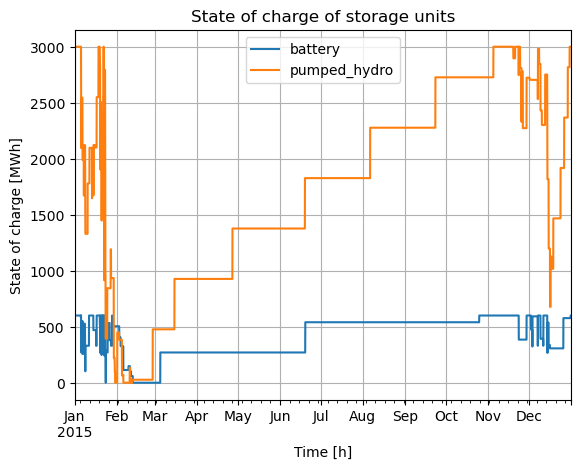

In [24]:
#plotting state of charge of storage units
network.storage_units_t.state_of_charge.plot()
plt.title('State of charge of storage units')
plt.xlabel('Time [h]')
plt.ylabel('State of charge [MWh]')
plt.legend(network.storage_units.index, loc='best')
plt.grid(True)
plt.show()

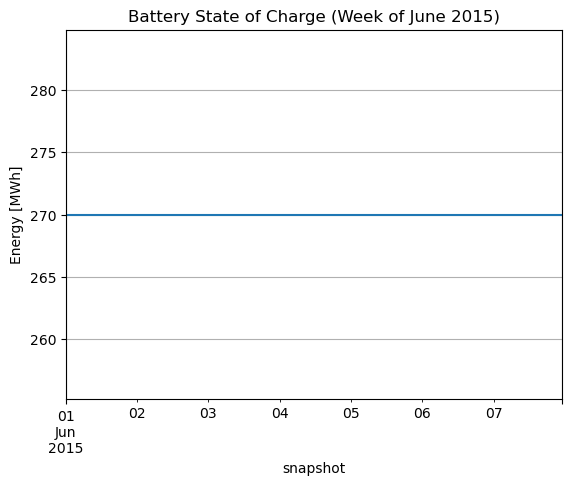

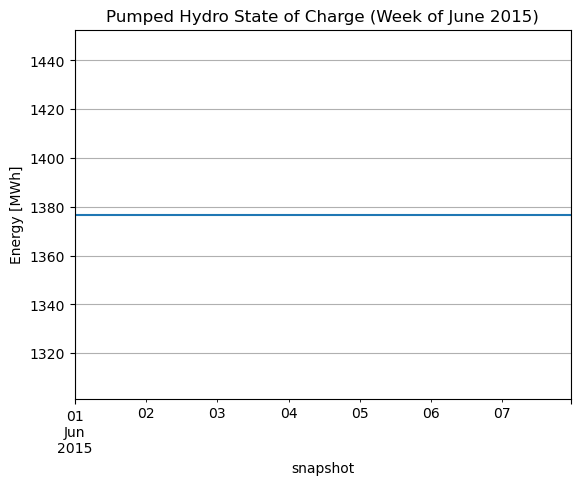

In [25]:
network.storage_units_t.state_of_charge["battery"].loc["2015-06-01":"2015-06-07"].plot()
plt.title("Battery State of Charge (Week of June 2015)")
plt.ylabel("Energy [MWh]")
plt.grid()
plt.show()

network.storage_units_t.state_of_charge["pumped_hydro"].loc["2015-06-01":"2015-06-07"].plot()
plt.title("Pumped Hydro State of Charge (Week of June 2015)")
plt.ylabel("Energy [MWh]")
plt.grid()
plt.show()

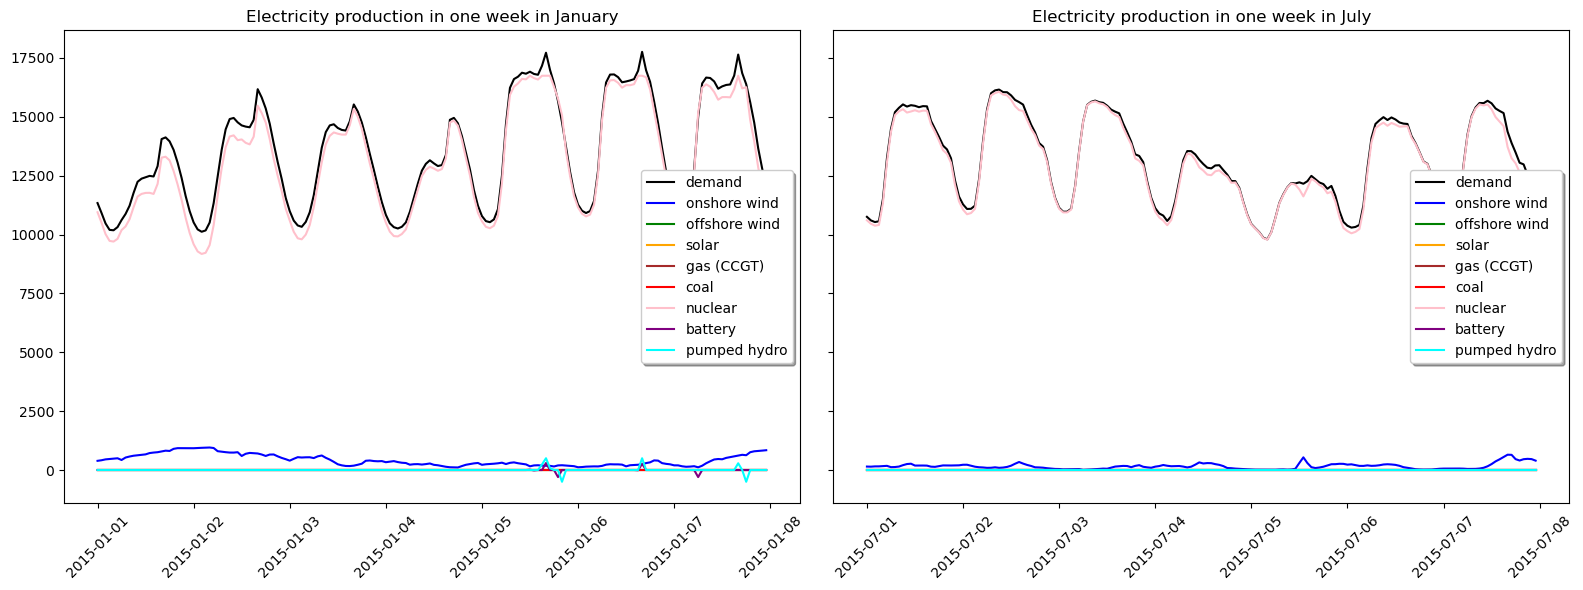

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].plot(network.storage_units_t.p['battery'][0:168], color='purple', label='battery')
axes[0].plot(network.storage_units_t.p['pumped_hydro'][0:168], color='cyan', label='pumped hydro')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].plot(network.storage_units_t.p['battery'][4344:4512], color='purple', label='battery')
axes[1].plot(network.storage_units_t.p['pumped_hydro'][4344:4512], color='cyan', label='pumped hydro')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Part E: target for decarbonization

In [27]:
co2_limit = 13e6  

co2_prices = []


network.remove("GlobalConstraint", "co2_limit")


network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})

co2_price = network.global_constraints.mu
co2_prices.append(co2_price)


print(f"CO2 Limit: {co2_limit / 1e6:.1f} Mt, CO2 Price: {co2_price}")


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 15.26it/s]
INFO:linopy.io: Writing time: 3.83s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-jsc3k2nl.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-jsc3k2nl.lp


Reading time = 0.67 seconds


INFO:gurobipy:Reading time = 0.67 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.82e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


CO2 Limit: 13.0 Mt, CO2 Price: GlobalConstraint
co2_limit   -97.876678
Name: mu, dtype: float64


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00,  8.91it/s]
INFO:linopy.io: Writing time: 5.93s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-irp7h6n8.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-irp7h6n8.lp


Reading time = 1.26 seconds


INFO:gurobipy:Reading time = 1.26 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 1.31e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 13.42it/s]
INFO:linopy.io: Writing time: 3.11s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-izzcaxlg.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-izzcaxlg.lp


Reading time = 0.86 seconds


INFO:gurobipy:Reading time = 0.86 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 9.90e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 12.22it/s]
INFO:linopy.io: Writing time: 3.21s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-ifqcskci.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-ifqcskci.lp


Reading time = 0.78 seconds


INFO:gurobipy:Reading time = 0.78 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 9.06e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 13.96it/s]
INFO:linopy.io: Writing time: 3.18s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-o2s02prp.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-o2s02prp.lp


Reading time = 0.76 seconds


INFO:gurobipy:Reading time = 0.76 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 8.34e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 13.53it/s]
INFO:linopy.io: Writing time: 3.12s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-sb5cqzoq.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-sb5cqzoq.lp


Reading time = 0.82 seconds


INFO:gurobipy:Reading time = 0.82 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 7.66e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 14.24it/s]
INFO:linopy.io: Writing time: 3.05s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-01zgea9b.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-01zgea9b.lp


Reading time = 0.85 seconds


INFO:gurobipy:Reading time = 0.85 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 7.09e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 12.75it/s]
INFO:linopy.io: Writing time: 3.13s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-3mrhc4u0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-3mrhc4u0.lp


Reading time = 0.63 seconds


INFO:gurobipy:Reading time = 0.63 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.79e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 14.05it/s]
INFO:linopy.io: Writing time: 3.14s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-mo5rhujo.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-mo5rhujo.lp


Reading time = 0.74 seconds


INFO:gurobipy:Reading time = 0.74 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.64e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 16.95it/s]
INFO:linopy.io: Writing time: 2.57s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-j5x23ia7.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-j5x23ia7.lp


Reading time = 0.61 seconds


INFO:gurobipy:Reading time = 0.61 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.55e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 12.06it/s]
INFO:linopy.io: Writing time: 3.3s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-h3yg6cmt.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-h3yg6cmt.lp


Reading time = 1.05 seconds


INFO:gurobipy:Reading time = 1.05 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.52e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


CO2 Prices for each CO2 limit:
CO2 Limit: 0.0 Mt, CO2 Price: GlobalConstraint
co2_limit   -2.414016e+06
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 2.2 Mt, CO2 Price: GlobalConstraint
co2_limit   -435.114071
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 4.4 Mt, CO2 Price: GlobalConstraint
co2_limit   -345.617891
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 6.6 Mt, CO2 Price: GlobalConstraint
co2_limit   -313.881096
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 8.8 Mt, CO2 Price: GlobalConstraint
co2_limit   -295.257384
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 11.1 Mt, CO2 Price: GlobalConstraint
co2_limit   -195.790772
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 13.3 Mt, CO2 Price: GlobalConstraint
co2_limit   -89.544153
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 15.5 Mt, CO2 Price: GlobalConstraint
co2_limit   -53.49823
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 17.7 Mt, CO2 Price: GlobalConstraint
co2_limit   -25.907186
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 19.9 Mt, CO2 Price: 

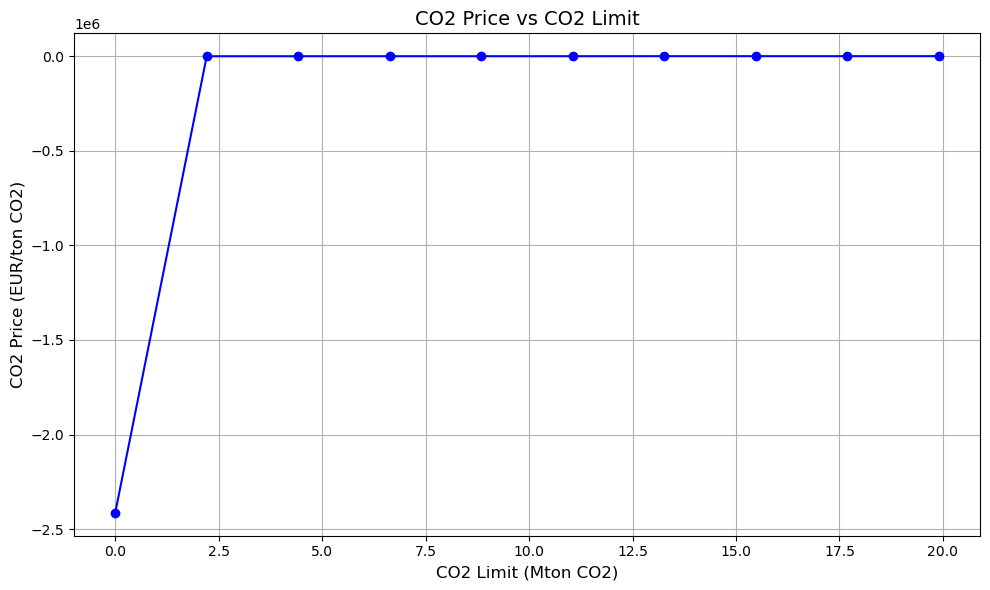

In [28]:
co2_limits = np.linspace(0, 19.9e6, 10)

co2_prices = []

for co2_limit in co2_limits:
    network.remove("GlobalConstraint", "co2_limit")
    
    network.add("GlobalConstraint",
                "co2_limit",
                type="primary_energy",
                carrier_attribute="co2_emissions",
                sense="<=",
                constant=co2_limit)
    
    network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})
    
    co2_price = network.global_constraints.mu
    co2_prices.append(co2_price)

print("CO2 Prices for each CO2 limit:")
for co2_limit, co2_price in zip(co2_limits, co2_prices):
    print(f"CO2 Limit: {co2_limit / 1e6:.1f} Mt, CO2 Price: {co2_price} EUR/ton")


fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(co2_limits / 1e6, co2_prices, marker='o', linestyle='-', color='b')
ax1.set_xlabel('CO2 Limit (Mton CO2)', fontsize=12)
ax1.set_ylabel('CO2 Price (EUR/ton CO2)', fontsize=12)
ax1.set_title('CO2 Price vs CO2 Limit', fontsize=14)
ax1.grid(True)

plt.tight_layout()
plt.show()


In [29]:
import numpy as np

co2_limits = np.linspace(0, 19.9e6, 10)
co2_prices = []

for co2_limit in co2_limits:
    network.remove("GlobalConstraint", "co2_limit")
    network.add("GlobalConstraint",
                "co2_limit",
                type="primary_energy",
                carrier_attribute="co2_emissions",
                sense="<=",
                constant=co2_limit)
    network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})
    try:
        mu = network.global_constraints.at["co2_limit_13MT", "mu"]
        price = float(mu) if mu is not None else np.nan
    except:
        price = np.nan
    co2_prices.append(price)

co2_limits = np.array(co2_limits)
co2_prices = np.array(co2_prices)

valid = ~np.isnan(co2_prices)
co2_limits_clean = co2_limits[valid]
co2_prices_clean = co2_prices[valid]

sorted_indices = np.argsort(co2_prices_clean)
co2_prices_sorted = co2_prices_clean[sorted_indices]
co2_limits_sorted = co2_limits_clean[sorted_indices]

if len(co2_prices_sorted) >= 2:
    target_price = -88
    co2_limit_target = np.interp(target_price, co2_prices_sorted, co2_limits_sorted)
    print(f"{co2_limit_target / 1e6:.1f} Mt")
else:
    print("Not enough valid values")


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]
INFO:linopy.io: Writing time: 8.31s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-q_r08q5u.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-q_r08q5u.lp


Reading time = 0.76 seconds


INFO:gurobipy:Reading time = 0.76 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 1.31e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00,  9.89it/s]
INFO:linopy.io: Writing time: 4.83s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-3t3edc37.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-3t3edc37.lp


Reading time = 0.81 seconds


INFO:gurobipy:Reading time = 0.81 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 9.90e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 14.81it/s]
INFO:linopy.io: Writing time: 2.91s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-ym8zoyvb.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-ym8zoyvb.lp


Reading time = 0.82 seconds


INFO:gurobipy:Reading time = 0.82 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 9.06e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 10.73it/s]
INFO:linopy.io: Writing time: 3.72s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-oofqygpa.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-oofqygpa.lp


Reading time = 0.93 seconds


INFO:gurobipy:Reading time = 0.93 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 8.34e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 14.51it/s]
INFO:linopy.io: Writing time: 2.97s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-wpqyocra.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-wpqyocra.lp


Reading time = 0.83 seconds


INFO:gurobipy:Reading time = 0.83 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 7.66e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 13.45it/s]
INFO:linopy.io: Writing time: 2.93s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-ev2vnd_7.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-ev2vnd_7.lp


Reading time = 0.77 seconds


INFO:gurobipy:Reading time = 0.77 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 7.09e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 12.32it/s]
INFO:linopy.io: Writing time: 3.11s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-fwhvrk5j.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-fwhvrk5j.lp


Reading time = 0.76 seconds


INFO:gurobipy:Reading time = 0.76 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.79e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 10.74it/s]
INFO:linopy.io: Writing time: 3.57s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-8n222vw_.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-8n222vw_.lp


Reading time = 0.68 seconds


INFO:gurobipy:Reading time = 0.68 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.64e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 15.38it/s]
INFO:linopy.io: Writing time: 2.75s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-qp2kvzo9.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-qp2kvzo9.lp


Reading time = 0.69 seconds


INFO:gurobipy:Reading time = 0.69 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.55e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:linopy.io: Writing time: 3.13s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-2w7mn0_3.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-2w7mn0_3.lp


Reading time = 0.75 seconds


INFO:gurobipy:Reading time = 0.75 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.52e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Not enough valid values


Part F: Connect your country with, at least, two neighbouring countries.

In [52]:
network.add("Bus", "electricity bus DNK", carrier="electricity")
network.add("Bus", "electricity bus GBR", carrier="electricity")



network.add("Link",
            "COBRAcable (NLD-DNK)",
            bus0="electricity bus NLD",
            bus1="electricity bus DNK",
            p_nom=700,
            p_min_pu=-1,
            length=325,
            capital_cost=857142.86)


network.add("Link",
            "BritNed (NLD-GBR)",
            bus0="electricity bus NLD",
            bus1="electricity bus GBR",
            p_nom=1000,  # Based on real-world capacity
            p_min_pu=-1,
            length=260,
            capital_cost=500000)

Index(['COBRAcable (NLD-DNK)'], dtype='object')
Index(['BritNed (NLD-GBR)'], dtype='object')


Index(['BritNed (NLD-GBR)'], dtype='object')

Part H. Analayzing the Effect of the Lion Battery Storage Project in the Netherlands

In [53]:
network.remove("Link", "COBRAcable (NLD-DNK)")
network.remove("Link", "BritNed (NLD-GBR)")
network.add("Carrier", "lion_battery", overwrite = True)
network.add("StorageUnit", "lion_battery", 
            bus="electricity bus",
            p_nom_max = 350,
            max_hours=4,
            p_nom_extendable = False,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=annuity(15, 0.07) * 300000,  # €/MW
            marginal_cost=0,
            carrier="battery",
            overwrite = True,
            cyclic_state_of_charge=True)

Index(['lion_battery'], dtype='object')

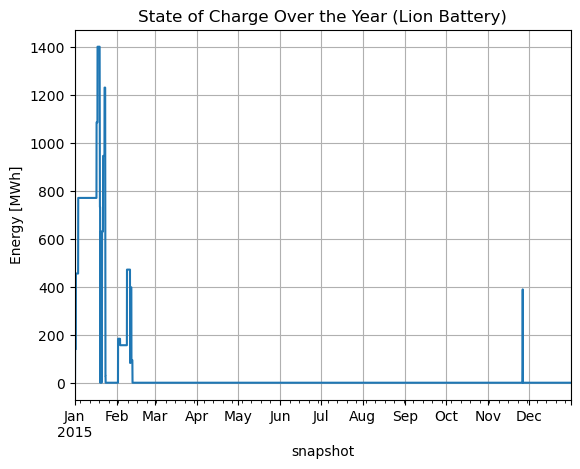

In [47]:
#Analyzing the impact of the lion battery on the network
network.storage_units_t.state_of_charge["lion_battery"].plot()
plt.title("State of Charge Over the Year (Lion Battery)")
plt.ylabel("Energy [MWh]")
plt.grid()
plt.show()

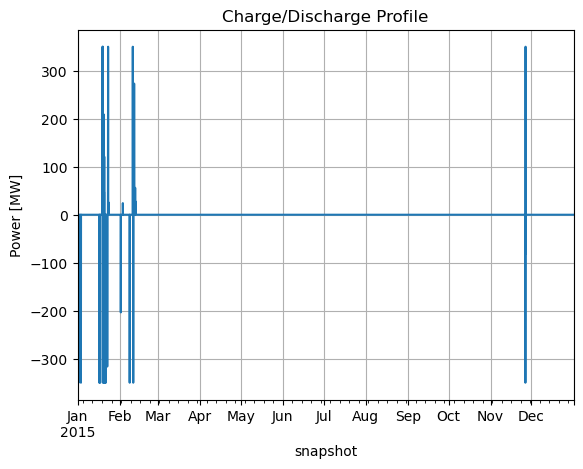

In [54]:
#Analyzing the Charging/Discharging Behavior of the Lion Battery
network.storage_units_t.p["lion_battery"].plot()
plt.title("Charge/Discharge Profile")
plt.ylabel("Power [MW]")
plt.grid()
plt.show()
